In [1]:
import os
import sys
import random
from pathlib import Path
import osgeo  #Needed for use on Windows only
import matplotlib.pyplot as plt
from rasterio import plot
from rasterio.plot import show
%matplotlib inline

In [2]:
sys.path.append(r"../src/collectcube")
from samplegen import *
from db import *

In [3]:
## aoi_in = shapefile or geopkg with polygon objet(s) sample form
aoi_in = Path("../data/EParaguay.shp")

## local_db_path is path where database will be stored
local_db_path = '../data/example/landcover.db'

## reference .tif with target crs and resolution
ref_ras = Path("../data/samp_ras.tif")

## output point shapefile
samppt_shapefile = "../data/example/pts_test.shp"
## output box shapefile (boxes around pixels for reference when viewing on imagery)
sampbox_shapefile = "../data/example/polys_test.shp"

res = 10


## Get random sample within polygon

aoi file has crs:epsg:32721


<Axes: >

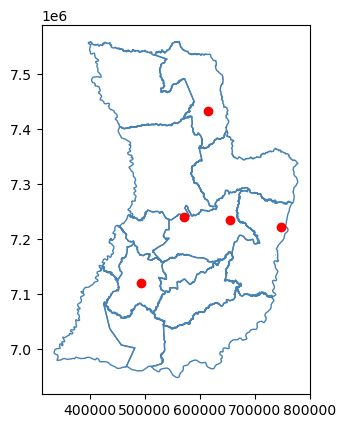

In [4]:
gs = get_sample_in_poly(aoi_in, sampsize = 5, seed=998, subpoly=None)

fig, ax = plt.subplots()
gdf = gpd.read_file(aoi_in)
gdf.plot(ax=ax, facecolor='none', edgecolor='steelblue')
gs.plot(ax=ax, color='r')

## Shift points to centroids of ref ras and make sample boxes

ref_ras has crs:EPSG:8858
Reprojecting aoi file to match image crs


<Axes: >

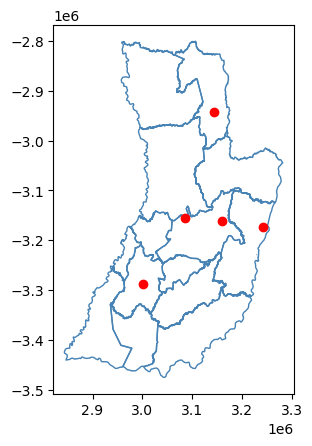

In [5]:
gs_shift = move_points_to_pixel_centroids(gs, ref_ras, write_pts=False)

## Plot again to make sure that crs is correctly matched
fig, ax = plt.subplots()
gdf = gpd.read_file(aoi_in)
if (gdf.crs != gs_shift.crs):
    print("Reprojecting aoi file to match image crs")
    gdf = gdf.to_crs(gs_shift.crs)
gdf.plot(ax=ax, facecolor='none', edgecolor='steelblue')
gs_shift.plot(ax=ax, color='r')

## get max pid in current sample (in case appending)
If no existing sample, will start with 0

In [6]:
maxpid = get_max_id_in_db(local_db_path)
print(f'current max pid is {maxpid}')

current max pid is -1


In [7]:
allpts = get_full_point_file(gs_shift, samppt_shapefile, res, lastpt=maxpid)
boxes = make_pixel_boxes_from_pts(allpts, sampbox_shapefile, res)

<class 'geopandas.geodataframe.GeoDataFrame'>
there are 40 neighbor pixels
there are 45 total pixels


In [4]:
zoom = find_poly_on_image(1, ref_ras, boxes)

## Make pixel table and insert in landcover database

In [9]:
ptsdf = make_pixel_table(samppt_shapefile,'example')

ptsdf.tail(n=5)

,PID,Center,cent_X,cent_Y,cent_lat,cent_long,ransamp,checked,PID0,PID1,sampgroup
40,0000004_4,0,3243200.0,-3173510.0,-25.107790,-54.547186,1,0,4,4,example
41,0000004_5,0,3243220.0,-3173510.0,-25.107790,-54.546967,1,0,4,5,example
42,0000004_6,0,3243200.0,-3173520.0,-25.107872,-54.547175,1,0,4,6,example
43,0000004_7,0,3243210.0,-3173520.0,-25.107872,-54.547065,1,0,4,7,example
44,0000004_8,0,3243220.0,-3173520.0,-25.107872,-54.546956,1,0,4,8,example


In [10]:
treat_existing = 'append' # 'replace' | 'append' | 'fail'
make_pixel_table_in_db(ptsdf, local_db_path, treat_existing)
table_check = check_table(local_db_path,'pixels')

In [13]:
## Check that primary key was made
meta = sa.MetaData()
table = sa.Table('pixels', meta, autoload_with=engine)
primaryKeyColNames = [pk_column.name for pk_column in table.primary_key.columns.values()]
print('Primary Key is {}'.format(primaryKeyColNames))

Primary Key is ['PID']


## Append second sample to first (to check functionality)

In [15]:
gs2 = get_sample_in_poly(aoi_in, sampsize = 5, seed=995, subpoly=None)
gs_shift2 = move_points_to_pixel_centroids(gs2, ref_ras, write_pts=False)
maxpid2 = get_max_id_in_db(local_db_path)
samppt_shapefile2 = "../data/example/pts_test2.shp"
sampbox_shapefile2 = "../data/example/polys_test2.shp"
allpts2 = get_full_point_file(gs_shift2, samppt_shapefile2, res, lastpt=maxpid2)
boxes2 = make_pixel_boxes_from_pts(allpts, sampbox_shapefile2, res)
ptsdf2 = make_pixel_table(samppt_shapefile2,'example2')
make_pixel_table_in_db(ptsdf2, local_db_path, 'append')
table_check = check_table(local_db_path,'pixels')

aoi file has crs:epsg:32721
ref_ras has crs:EPSG:8858
<class 'geopandas.geodataframe.GeoDataFrame'>
there are 40 neighbor pixels
there are 45 total pixels
         PID  Center     cent_X     cent_Y   cent_lat  cent_long  ransamp  \
0  0000000_0       1  3085110.0 -3155290.0 -24.958659 -56.294037        1   
1  0000001_0       1  3160910.0 -3160920.0 -25.004731 -55.459989        1   
2  0000002_0       1  3001240.0 -3288120.0 -26.048083 -57.074549        1   
3  0000003_0       1  3143490.0 -2941820.0 -23.218212 -55.869026        1   
4  0000004_0       1  3243210.0 -3173510.0 -25.107790 -54.547076        1   

   checked  PID0  PID1 sampgroup  
0        0     0     0   example  
1        0     1     0   example  
2        0     2     0   example  
3        0     3     0   example  
4        0     4     0   example  
